<a href="https://colab.research.google.com/github/PandukaBandara99/ML-Books/blob/main/AdvancedTensorFlow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mahela Panduka Bandara ; <br> UG @ Dpt. of Electronic & Electrical Engineering ;<br> University of Peradeniya ;<br> 2024/05 <br><br> Email : e19039@end.pdn.ac.lk <br> LinkedIN : https://www.linkedin.com/in/pandukabandara/

Refferences: <br>
1 - https://www.coursera.org/specializations/tensorflow-advanced-techniques

## From the Previous Note#

### Custom Callbacks

#### Introduction

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.15.0


In [ ]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


Now, define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

Providing a callback to model methods such as tf.keras.Model.fit() ensures the methods are called at those stages:



In [ ]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 05:06:53.631340
Training: batch 0 ends at 05:06:55.872047
Training: batch 1 begins at 05:06:55.872983
Training: batch 1 ends at 05:06:55.878866
Training: batch 2 begins at 05:06:55.880221
Training: batch 2 ends at 05:06:55.891222
Training: batch 3 begins at 05:06:55.893292
Training: batch 3 ends at 05:06:55.897315
Training: batch 4 begins at 05:06:55.898569
Training: batch 4 ends at 05:06:55.901915


**An overview of callback methods**
Common methods for training/testing/predicting
> For training, testing, and predicting, following methods are provided to be overridden.

`on_(train|test|predict)_begin(self, logs=None)` <br>

> Called at the beginning of `fit/evaluate/predict.`

`on_(train|test|predict)_end(self, logs=None)` <br>

> Called at the end of `fit/evaluate/predict.`

`on_(train|test|predict)_batch_begin(self, batch, logs=None)` <br>

> Called right before processing a batch during training/testing/predicting. Within this method, logs is a dict with batch and size available keys, representing the current batch number and the size of the batch.

`on_(train|test|predict)_batch_end(self, batch, logs=None)`<br>

> Called at the end of training/testing/predicting a batch. Within this method, logs is a dict containing the stateful metrics result.

**Training specific methods**
In addition, for training, following are provided.

`on_epoch_begin(self, epoch, logs=None)`

> Called at the beginning of an epoch during training.

`on_epoch_end(self, epoch, logs=None)`
> Called at the end of an epoch during training.

#### Usage of `logs dict`


The logs dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [ ]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs:
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.72
Epoch: 1, Val/Train loss ratio: 0.91
Epoch: 2, Val/Train loss ratio: 0.94


In [ ]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.73
Stopping training...


Similarly, one can provide callbacks in `evaluate()` calls.



#### Custom callback to Visualize predictions

In [ ]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]:
            t.set_color('green')
        else:
            t.set_color('red')
    plt.grid(None)

In [ ]:
GIF_PATH = './animation.gif'

In [ ]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

1/1 [==============================] - 0s 82ms/step


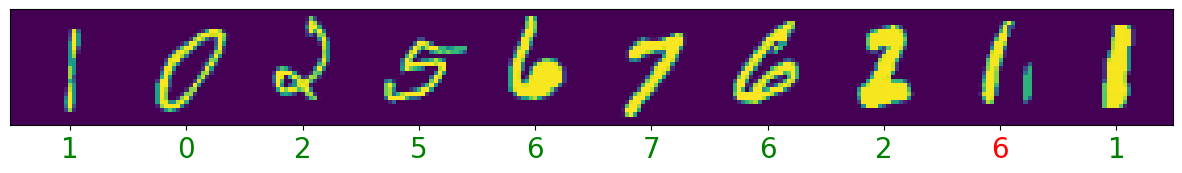

1/1 [==============================] - 0s 37ms/step


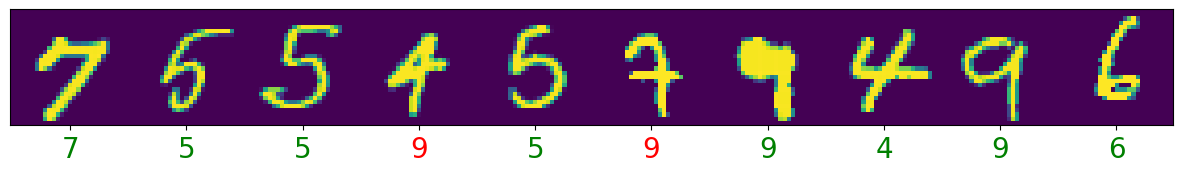

1/1 [==============================] - 0s 21ms/step


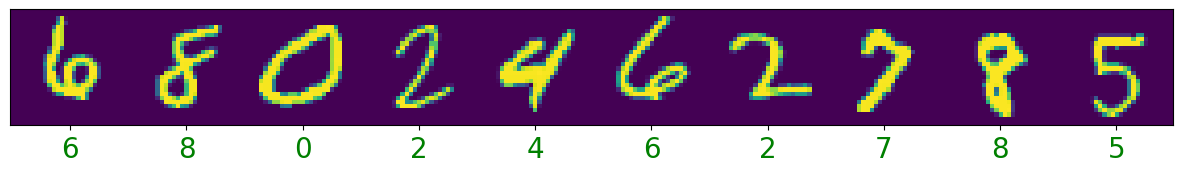

In [ ]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

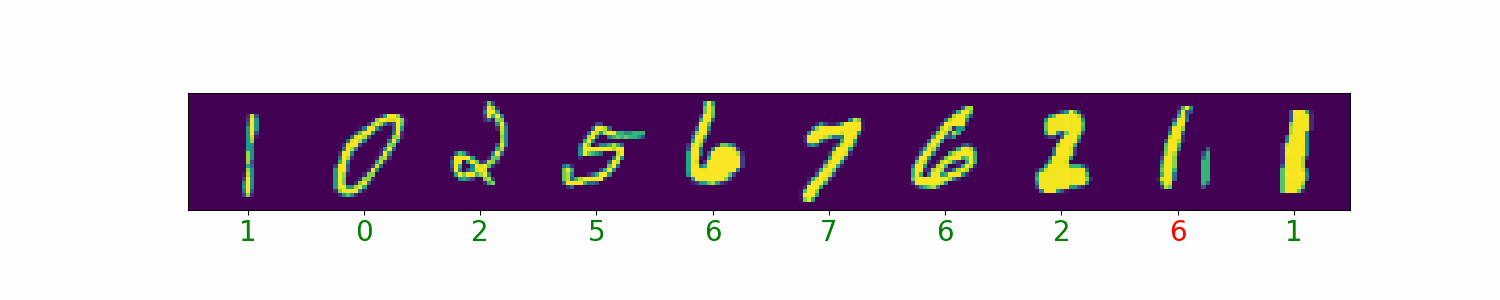

In [ ]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE)

# 2.0 Custom and Distributed Training with TensorFlow

## 2.1 Tensors

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Basic Tensor operations

Create a single dimension numpy array on which you can perform some operation. You'll make an array of size 25, holding values from 0 to 24.

In [3]:
# Create a 1D uint8 NumPy array comprising of first 25 natural numbers
x = np.arange(0, 25)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

To change that array into a tensor,

In [4]:
# Convert NumPy array to Tensor using `tf.constant`
x = tf.constant(x)
x

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])>

Now the tensor operations can be applied. As an example apply square (element-wise) all the values in the tensor x

In [5]:
# Square the input tensor x
x = tf.square(x)
x

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])>

### Tensor Reshape

One feature of tensors is that they can be reshaped. When reshpaing, make sure to consider then dimensions that will include all of the values of the tensor.

In [6]:
# Reshape tensor x into a 5 x 5 matrix.
x = tf.reshape(x, (5, 5))
x

<tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[  0,   1,   4,   9,  16],
       [ 25,  36,  49,  64,  81],
       [100, 121, 144, 169, 196],
       [225, 256, 289, 324, 361],
       [400, 441, 484, 529, 576]])>

In [9]:
# Cast tensor x into float32. Notice the change in the dtype.
x = tf.cast(x, tf.float32)
x

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  0.,   1.,   4.,   9.,  16.],
       [ 25.,  36.,  49.,  64.,  81.],
       [100., 121., 144., 169., 196.],
       [225., 256., 289., 324., 361.],
       [400., 441., 484., 529., 576.]], dtype=float32)>

When using tf.constant(), you can pass in a 1D array (a vector) and set the shape parameter to turn this vector into a multi-dimensional array.

In [14]:
tf.constant([1,2,3,4], shape=(2,2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

**However, that for tf.Variable()**, the shape of the tensor is derived from the shape given by the input array. Setting shape to something other than None will not reshape a 1D array into a multi-dimensional array, and will give a ValueError.

In [15]:
try:
    # This will produce a ValueError
    tf.Variable([1,2,3,4], shape=(2,2))
except ValueError as v:
    # See what the ValueError says
    print(v)

In this `tf.Variable` creation, the initial value's shape ((4,)) is not compatible with the explicitly supplied `shape` argument ((2, 2)).


### Broadcasting in Tensors

create a single value float tensor by the help of which will help to see broadcasting in actionC

In [7]:
# Let's define a constant and see how broadcasting works in the following cell.
y = tf.constant(2, dtype=tf.float32)
y

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

Multiply the tensors x and y together, and notice how multiplication was done and its result.

In [10]:
# Multiply tensor `x` and `y`. `y` is multiplied to each element of x.
result = tf.multiply(x, y)
result

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[   0.,    2.,    8.,   18.,   32.],
       [  50.,   72.,   98.,  128.,  162.],
       [ 200.,  242.,  288.,  338.,  392.],
       [ 450.,  512.,  578.,  648.,  722.],
       [ 800.,  882.,  968., 1058., 1152.]], dtype=float32)>

Re-Initialize y to a tensor having more values.

In [11]:
# Now let's define an array that matches the number of row elements in the `x` array.
y = tf.constant([1, 2, 3, 4, 5], dtype=tf.float32)
y

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 2., 3., 4., 5.], dtype=float32)>

In [12]:
# Let's see first the contents of `x` again.
x  # |=> not affected

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  0.,   1.,   4.,   9.,  16.],
       [ 25.,  36.,  49.,  64.,  81.],
       [100., 121., 144., 169., 196.],
       [225., 256., 289., 324., 361.],
       [400., 441., 484., 529., 576.]], dtype=float32)>

In [13]:
# Add tensor `x` and `y`. `y` is added element wise to each row of `x`.
result = x + y
result

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[  1.,   3.,   7.,  13.,  21.],
       [ 26.,  38.,  52.,  68.,  86.],
       [101., 123., 147., 173., 201.],
       [226., 258., 292., 328., 366.],
       [401., 443., 487., 533., 581.]], dtype=float32)>

## 2.2 Gradient Tape

Gradient Tape is a powerful feature in TensorFlow that facilitates automatic differentiation.Gradient Tape is part of TensorFlow's eager execution mode, which allows operations to be evaluated immediately as they are called within Python.

TensorFlow's `tf.GradientTape` records operations for automatic differentiation. Specifically, it records computations made within its context (i.e., between the `GradientTape` `__enter__` and `__exit__` methods) to compute the gradient of some target variables with respect to some source variables.


#### How Gradient Tape Works

1. **Recording Operations:** When you perform operations within the context of a `GradientTape`, TensorFlow records these operations.
2. **Computing Gradients:** Once the operations are recorded, you can use the tape to compute the gradients of a target (typically a loss value) with respect to some source variables (typically model parameters).

To use `tf.GradientTape`:

1. **Define the Model and Loss Function:** You need a model that performs some operations on input data and a loss function to evaluate the performance of the model.
2. **Open a Gradient Tape Context:** Use `with tf.GradientTape() as tape:` to start recording the operations.
3. **Perform Operations within the Context:** Perform the forward pass of the model and compute the loss within the `GradientTape` context.
4. **Compute Gradients:** Use the `tape.gradient(target, sources)` method to compute the gradients of the target with respect to the sources.
5. **Apply Gradients:** Use an optimizer to apply the computed gradients to the model's variables.


#### Example

```python
import tensorflow as tf

# Create a simple model with a single Dense layer
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

# Define an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define a simple mean squared error loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Input data (e.g., features) and true labels
x = tf.constant([[1.0], [2.0], [3.0], [4.0]])
y_true = tf.constant([[2.0], [4.0], [6.0], [8.0]])

# Training step function
def train_step(x, y_true):
    with tf.GradientTape() as tape:
        # Forward pass: compute predicted y by passing x to the model
        y_pred = model(x, training=True)
        
        # Compute the loss
        loss = loss_fn(y_true, y_pred)
    
    # Compute gradients of the loss with respect to model's variables
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# Training loop
for epoch in range(100):
    loss = train_step(x, y_true)
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")
```


#### Important Points

- **Persistent Tapes:** By default, a `tf.GradientTape` is used only once to compute gradients. If you need to compute multiple gradients over the same computation, create a persistent tape by passing `persistent=True` to the `GradientTape` constructor. Remember to delete the tape with `del tape` when done to free resources.
- **Nested Tapes:** You can nest multiple `tf.GradientTape` contexts to compute higher-order derivatives (gradients of gradients).

Example of using a persistent tape:
```python
with tf.GradientTape(persistent=True) as tape:
    # Perform operations
    pass
# Compute gradients multiple times
gradients = tape.gradient(target, sources)
# After usage
del tape
```

#### Use Cases

- **Training Neural Networks:** Calculating gradients of the loss function with respect to model parameters.
- **Custom Training Loops:** Implementing complex training algorithms that require manual gradient calculations.
- **Higher-order Gradients:** Computing gradients of gradients for advanced optimization techniques.



#### Example

In [18]:
# Define a 2x2 array of 1's
x = tf.ones((2,2))

with tf.GradientTape() as t:
    # Record the actions performed on tensor x with `watch`
    t.watch(x)

    # Define y as the sum of the elements in x
    y =  tf.reduce_sum(x)
    print("y : ",y)

    # Let z be the square of y
    z = tf.square(y)
    print("z : ",z)

# Get the derivative of z wrt the original input tensor x
dz_dx = t.gradient(z, x)

# Print our result
print(dz_dx)

y :  tf.Tensor(4.0, shape=(), dtype=float32)
z :  tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


**Gradient tape expires after one use, by default**

If you want to compute multiple gradients, note that by default, GradientTape is not persistent (`persistent=False`).  This means that the GradientTape will expire after you use it to calculate a gradient.

To see this, set up gradient tape as usual and calculate a gradient, so that the gradient tape will be 'expired'.

In [19]:
x = tf.constant(3.0)

# Notice that persistent is False by default
with tf.GradientTape() as t:
    t.watch(x)

    # y = x^2
    y = x * x

    # z = y^2
    z = y * y

# Compute dz/dx. 4 * x^3 at x = 3 --> 108.0
dz_dx = t.gradient(z, x)
print(dz_dx)

tf.Tensor(108.0, shape=(), dtype=float32)


In [20]:
# If you try to compute dy/dx after the gradient tape has expired:
try:
    dy_dx = t.gradient(y, x)  # 6.0
    print(dy_dx)
except RuntimeError as e:
    print("The error message you get is:")
    print(e)

The error message you get is:
A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


##### Make the gradient tape persistent

To make sure that the gradient tape can be used multiple times, set `persistent=True`

In [21]:
x = tf.constant(3.0)

# Set persistent=True so that you can reuse the tape
with tf.GradientTape(persistent=True) as t:
    t.watch(x)

    # y = x^2
    y = x * x

    # z = y^2
    z = y * y

# Compute dz/dx. 4 * x^3 at x = 3 --> 108.0
dz_dx = t.gradient(z, x)
print(dz_dx)

tf.Tensor(108.0, shape=(), dtype=float32)


In [ ]:
# You can still compute dy/dx because of the persistent flag.
dy_dx = t.gradient(y, x)  # 6.0
print(dy_dx)

Delete the tape variable `t` once you no longer need it.

In [22]:
# Drop the reference to the tape
del t

### Nested Gradient tapes
To compute a higher order derivative by nesting the `GradientTapes:`

**Acceptable indentation of the first gradient calculation**
Keep in mind that need to make sure that the first gradient calculation of `dy_dx` should occur at least inside the outer `with` block.

In [23]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

    # The first gradient calculation should occur at least
    # within the outer with block
    dy_dx = tape_1.gradient(y, x)
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


The first gradient calculation can also be inside the inner with block.

In [24]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        # The first gradient calculation can also be within the inner with block
        dy_dx = tape_1.gradient(y, x)
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


**Where not to indent the first gradient calculation**
If the first gradient calculation is OUTSIDE of the outer `with` block, it won't persist for the second gradient calculation.

In [25]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

# The first gradient call is outside the outer with block
# so the tape will expire after this
dy_dx = tape_1.gradient(y, x)

# The tape is now expired and the gradient output will be `None`
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
None


Notice how the `d2y_dx2` calculation is now `None`.  The tape has expired.  Also note that this still won't work even if you set persistent=True for both gradient tapes.

In [26]:
x = tf.Variable(1.0)

# Setting persistent=True still won't work
with tf.GradientTape(persistent=True) as tape_2:
    # Setting persistent=True still won't work
    with tf.GradientTape(persistent=True) as tape_1:
        y = x * x * x

# The first gradient call is outside the outer with block
# so the tape will expire after this
dy_dx = tape_1.gradient(y, x)

# the output will be `None`
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
None


 **Proper indentation for the second gradient calculation**

The second gradient calculation `d2y_dx2` can be indented as much as the first calculation of `dy_dx` but not more.

In [27]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

        # this is acceptable
        d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


Tis is also acceptable,

In [28]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

    # this is also acceptable
    d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


or

In [29]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)

# this is also acceptable
d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


## 2.3 Custom Training Loops

Steps to training network,
1. Define the network
2. Prepare the training data
3. Define loss and optimizer
4. Train the model on training inputs by minimizing loss using custom optimizer.
5. Validate the model.


#### Define the network

Define your model as a class.
- `x` is the input tensor.
- The model should output values of **wx+b**.
- Start off by initializing w and b to random values.
- During the training process, values of w and b get updated in accordance with linear regression so as to minimize the loss incurred by the model.
- Once arrive at optimal values for w and b, the model would have been trained to correctly predict the values of wx+b.

Hence,
- **w** and **b** are trainable weights of the model.
- **x** is the input
- **y** = wx + b is the output

In [3]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `2.0` and the bias to `1.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.w = tf.Variable(2.0)
    self.b = tf.Variable(1.0)

  def __call__(self, x):
    return self.w * x + self.b

model = Model()

#### Define a loss function



A loss function measures how well the output of a model for a given input matches the target output.
- The goal is to minimize this difference during training.
- Use the standard L2 loss, also known as the least square errors
$$Loss = \sum_{i} \left (y_{pred}^i - y_{target}^i \right )^2$$

In [4]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

#### Obtain training data



First, synthesize the training data using the "true" w and "true" b.

$$y = w_{true} \times x + b_{true} $$

In [5]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

xs  = tf.random.normal(shape=[NUM_EXAMPLES])

ys = (TRUE_w * xs) + TRUE_b

#### Define a training loop


With the network and training data, train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
- Gradient descent updates the trainable weights **w** and **b** to reduce the loss.


There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`.
- Use `tf.GradientTape` for automatic differentiation
- Use `tf.assign_sub` for decrementing a value.  Note that assign_sub combines `tf.assign` and `tf.sub`

In [6]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dw, db = t.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

  return current_loss

Finally, iteratively run through the training data and see how `w` and `b` evolve.

In [7]:
model = Model()

# Collect the history of W-values and b-values to plot later
list_w, list_b = [], []
epochs = range(15)
losses = []
for epoch in epochs:
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print('Epoch %2d: w=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, list_w[-1], list_b[-1], current_loss))

Epoch  0: w=2.00 b=1.00, loss=1.99266
Epoch  1: w=2.20 b=1.20, loss=1.27763
Epoch  2: w=2.36 b=1.36, loss=0.81918
Epoch  3: w=2.49 b=1.48, loss=0.52524
Epoch  4: w=2.59 b=1.59, loss=0.33677
Epoch  5: w=2.67 b=1.67, loss=0.21593
Epoch  6: w=2.74 b=1.73, loss=0.13845
Epoch  7: w=2.79 b=1.79, loss=0.08877
Epoch  8: w=2.83 b=1.83, loss=0.05692
Epoch  9: w=2.87 b=1.86, loss=0.03650
Epoch 10: w=2.89 b=1.89, loss=0.02340
Epoch 11: w=2.91 b=1.91, loss=0.01501
Epoch 12: w=2.93 b=1.93, loss=0.00962
Epoch 13: w=2.95 b=1.94, loss=0.00617
Epoch 14: w=2.96 b=1.95, loss=0.00396


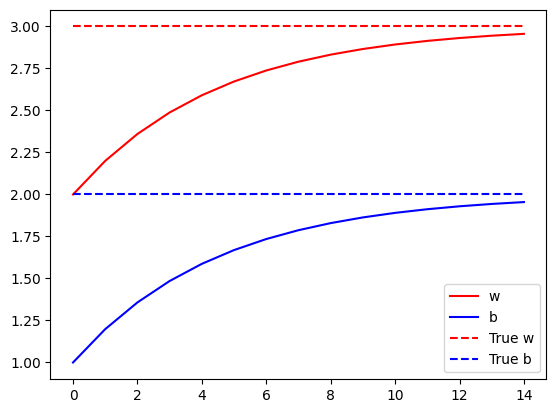

In [10]:
import matplotlib.pyplot as plt
plt.plot(epochs, list_w, 'r',
       epochs, list_b, 'b')
plt.plot([TRUE_w] * len(epochs), 'r--',
      [TRUE_b] * len(epochs), 'b--')
plt.legend(['w', 'b', 'True w', 'True b'])
plt.show()

**Plots for Evaluation**


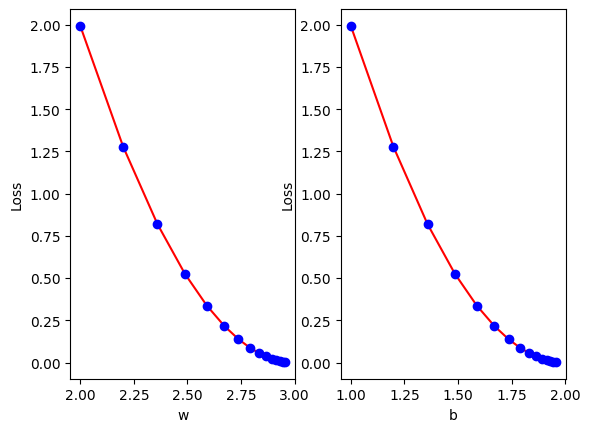

In [12]:
def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')


weights_list = [{ 'name' : "w",
                  'values' : list_w
                },
                {
                  'name' : "b",
                  'values' : list_b
                }]

plot_loss_for_weights(weights_list, losses)

#### Fashion MNIST using Custom Training Loop

In [32]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [33]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [54]:
# Load the Fashion MNIST dataset
(train_data, test_data), info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


In [55]:
# Define a function to normalize and reshape the images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    image = tf.reshape(image, [-1])  # Ensure the shape is flatten
    return image, label

# Apply the preprocess function to the training and test datasets
train_data = train_data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets for performance optimization
#train_data = train_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
#test_data = test_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [56]:
batch_size = 32
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

**Define the Model**
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [57]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

**Define Optimizer and Loss Function**

Chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [58]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

**Define Metrics**

Define metrics so that training loop can update and display them. Here use `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [59]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

**Building Training Loop**

In [60]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

This function performs training during one epoch.Run through all batches of training data in each epoch to make updates to trainable weights using the previous function. See that also call `update_state`  metrics to accumulate the value of the metrics.


In [61]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

      losses.append(loss_value)

      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [62]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Now combine the functions to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

In [63]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 1874: 0.3625: 100%|██████████| 1875/1875 



 Epoch 0: Train loss: 0.5052  Validation Loss: 0.4661, Train Accuracy: 0.8213, Validation Accuracy 0.8246
Start of epoch 1


Training loss for step 1874: 0.3816: 100%|██████████| 1875/1875 



 Epoch 1: Train loss: 0.3788  Validation Loss: 0.3819, Train Accuracy: 0.8627, Validation Accuracy 0.8611
Start of epoch 2


Training loss for step 1874: 0.3225: 100%|██████████| 1875/1875 



 Epoch 2: Train loss: 0.3427  Validation Loss: 0.3680, Train Accuracy: 0.8748, Validation Accuracy 0.8671
Start of epoch 3


Training loss for step 1874: 0.1102: 100%|██████████| 1875/1875 



 Epoch 3: Train loss: 0.3222  Validation Loss: 0.3656, Train Accuracy: 0.8821, Validation Accuracy 0.8706
Start of epoch 4


Training loss for step 1874: 0.6132: 100%|██████████| 1875/1875 



 Epoch 4: Train loss: 0.3066  Validation Loss: 0.3553, Train Accuracy: 0.8868, Validation Accuracy 0.8745
Start of epoch 5


Training loss for step 1874: 0.2095: 100%|██████████| 1875/1875 



 Epoch 5: Train loss: 0.2920  Validation Loss: 0.3600, Train Accuracy: 0.8925, Validation Accuracy 0.8711
Start of epoch 6


Training loss for step 1874: 0.3055: 100%|██████████| 1875/1875 



 Epoch 6: Train loss: 0.2797  Validation Loss: 0.3514, Train Accuracy: 0.8952, Validation Accuracy 0.8779
Start of epoch 7


Training loss for step 1874: 0.1319: 100%|██████████| 1875/1875 



 Epoch 7: Train loss: 0.2678  Validation Loss: 0.3792, Train Accuracy: 0.9003, Validation Accuracy 0.8641
Start of epoch 8


Training loss for step 1874: 0.3973: 100%|██████████| 1875/1875 



 Epoch 8: Train loss: 0.2574  Validation Loss: 0.3627, Train Accuracy: 0.9032, Validation Accuracy 0.8712
Start of epoch 9


Training loss for step 1874: 0.3616: 100%|██████████| 1875/1875 



 Epoch 9: Train loss: 0.2506  Validation Loss: 0.3642, Train Accuracy: 0.9054, Validation Accuracy 0.8727
